In [10]:
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D
from tensorflow.keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

# This line is needed to use CUDA on my linux box
os.environ['XLA_FLAGS']='--xla_gpu_cuda_data_dir=/usr/lib/cuda'

## Load datasets

In [7]:
# Load and Preprocess data MNIST data
(mnist_train_images, mnist_train_labels), (mnist_test_images, mnist_test_labels) = mnist.load_data()

mnist_train_images = np.array([tf.image.resize(img[..., tf.newaxis], [32, 32]).numpy() for img in mnist_train_images])
mnist_test_images = np.array([tf.image.resize(img[..., tf.newaxis], [32, 32]).numpy() for img in mnist_test_images])

mnist_train_labels = to_categorical(mnist_train_labels)
mnist_test_labels = to_categorical(mnist_test_labels)

mnist_train_images = mnist_train_images / 255.0
mnist_test_images = mnist_test_images / 255.0

In [13]:
# Load and preprocess CIFAR-10 data
(cifar10_train_images, cifar10_train_labels), (cifar10_test_images, cifar10_test_labels) = cifar10.load_data()

# cifar10_train_images = np.array([tf.image.resize(img, [32, 64]).numpy() for img in cifar10_train_images])
# cifar10_test_images = np.array([tf.image.resize(img, [64, 64]).numpy() for img in cifar10_test_images])

cifar10_train_images = cifar10_train_images / 255.0
cifar10_test_images = cifar10_test_images / 255.0

cifar10_train_labels = to_categorical(cifar10_train_labels)
cifar10_test_labels = to_categorical(cifar10_test_labels)

In [21]:
#Load and preprocess Tiny Imagenet data
# rescale images and set aside 20% of data for validation
data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2) 

tiny_imagenet_train_gen = data_gen.flow_from_directory(
    '/home/robert/Dev/cs5870-assignment-1/data/tiny-imagenet-200/train',
    target_size=(64, 64),  # Resize to the actual image size
    batch_size=64,
    class_mode='categorical',
    subset='training'  # Specify this is for training data
)

# Validation generator: Similarly, for validation
tiny_imagenet_val_gen = data_gen.flow_from_directory(
    '/home/robert/Dev/cs5870-assignment-1/data/tiny-imagenet-200/train',
    target_size=(64, 64),
    batch_size=64,
    class_mode='categorical',
    subset='validation'  # Specify this is for validation data
)

Found 80000 images belonging to 200 classes.
Found 20000 images belonging to 200 classes.


In [8]:
# Build the VGG16 model for MNIST
model = Sequential()
model.add(VGG16(include_top=False, weights=None, input_shape=(32, 32, 1)))
model.add(Flatten())
model.add(Dense(10, activation="softmax"))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14713536  
                                                                 
 flatten_2 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                5130      
                                                                 
Total params: 14718666 (56.15 MB)
Trainable params: 14718666 (56.15 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
# Create callback for saving model
checkpoint = ModelCheckpoint('../models/vgg16_mnist.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
# Train VGG16 for MNIST
mnist_history = model.fit(mnist_train_images, mnist_train_labels,
                    epochs=20,
                    batch_size=1024,
                    validation_data=(mnist_test_images, mnist_test_labels),
                    callbacks=[checkpoint])

Epoch 1/20
59/59 [==============================] - ETA: 0s - loss: 2.2784 - accuracy: 0.1272
Epoch 1: val_accuracy improved from -inf to 0.24350, saving model to ../models/vgg16_mnist.h5
59/59 [==============================] - 4s 49ms/step - loss: 2.2784 - accuracy: 0.1272 - val_loss: 1.9641 - val_accuracy: 0.2435
Epoch 2/20
59/59 [==============================] - ETA: 0s - loss: 1.3304 - accuracy: 0.4812
Epoch 2: val_accuracy improved from 0.24350 to 0.70270, saving model to ../models/vgg16_mnist.h5
59/59 [==============================] - 3s 47ms/step - loss: 1.3304 - accuracy: 0.4812 - val_loss: 0.6989 - val_accuracy: 0.7027
Epoch 3/20
59/59 [==============================] - ETA: 0s - loss: 0.4156 - accuracy: 0.8594
Epoch 3: val_accuracy improved from 0.70270 to 0.95670, saving model to ../models/vgg16_mnist.h5
59/59 [==============================] - 3s 48ms/step - loss: 0.4156 - accuracy: 0.8594 - val_loss: 0.1451 - val_accuracy: 0.9567
Epoch 4/20
59/59 [======================

In [11]:
# Model evaluation
model = load_model('../models/vgg16_mnist.h5')
test_loss, test_acc = model.evaluate(mnist_test_images, mnist_test_labels)
print("Test Accuracy:", test_acc)

313/313 [==============================] - 1s 3ms/step - loss: 0.0252 - accuracy: 0.9941
Test Accuracy: 0.9940999746322632


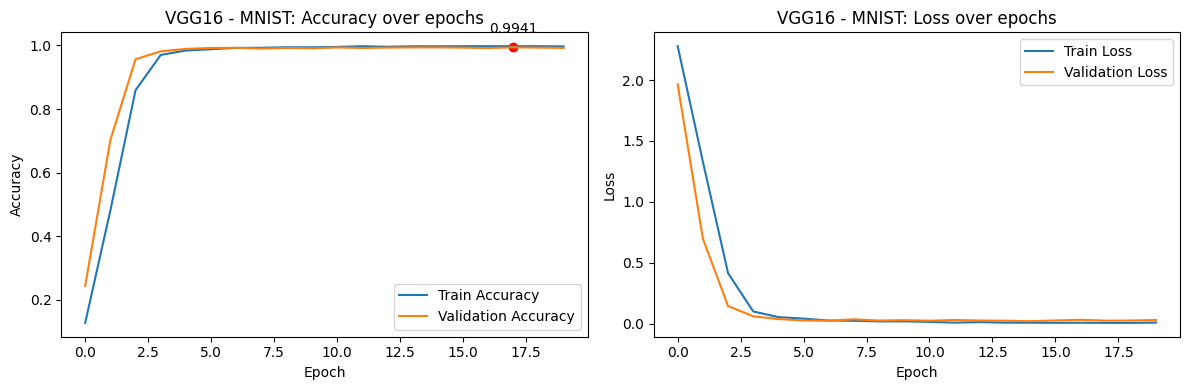

In [12]:
plt.figure(figsize=(12, 4))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(mnist_history.history['accuracy'], label='Train Accuracy')
plt.plot(mnist_history.history['val_accuracy'], label='Validation Accuracy')

# Annotate the maximum validation accuracy
max_val_acc = max(mnist_history.history['val_accuracy'])
max_val_acc_idx = mnist_history.history['val_accuracy'].index(max_val_acc)
plt.scatter(max_val_acc_idx, max_val_acc, color='red') # Highlight the max value with a red dot
plt.annotate(f'{max_val_acc:.4f}', (max_val_acc_idx, max_val_acc), textcoords="offset points", xytext=(0,10), ha='center') # Annotate the value

plt.title('VGG16 - MNIST: Accuracy over epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(mnist_history.history['loss'], label='Train Loss')
plt.plot(mnist_history.history['val_loss'], label='Validation Loss')
plt.title('VGG16 - MNIST: Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
# Build the VGG16 model for CIFAR-10
model = Sequential()
model.add(VGG16(include_top=False, weights=None, input_shape=(32, 32, 3)))
model.add(Flatten())
model.add(Dense(10, activation="softmax"))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                5130      
                                                                 
Total params: 14719818 (56.15 MB)
Trainable params: 14719818 (56.15 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
# Train VGG16 for CIFAR-10
cifar10_history = model.fit(cifar10_train_images, cifar10_train_labels,
                    epochs=20,
                    batch_size=256,
                    validation_data=(cifar10_test_images, cifar10_test_labels))

Epoch 1/20
196/196 [==============================] - 6s 19ms/step - loss: 2.3028 - accuracy: 0.0967 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 2/20
196/196 [==============================] - 3s 17ms/step - loss: 2.3027 - accuracy: 0.0974 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 3/20
196/196 [==============================] - 3s 16ms/step - loss: 2.3027 - accuracy: 0.0985 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 4/20
196/196 [==============================] - 3s 16ms/step - loss: 2.3027 - accuracy: 0.0997 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 5/20
196/196 [==============================] - 3s 16ms/step - loss: 2.3027 - accuracy: 0.0968 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 6/20
196/196 [==============================] - 3s 16ms/step - loss: 2.3027 - accuracy: 0.0980 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 7/20
196/196 [==============================] - 3s 15ms/step - loss: 2.3027 - accuracy: 0.0978 - val_loss: 2.3026 - val_accuracy: 0.1000

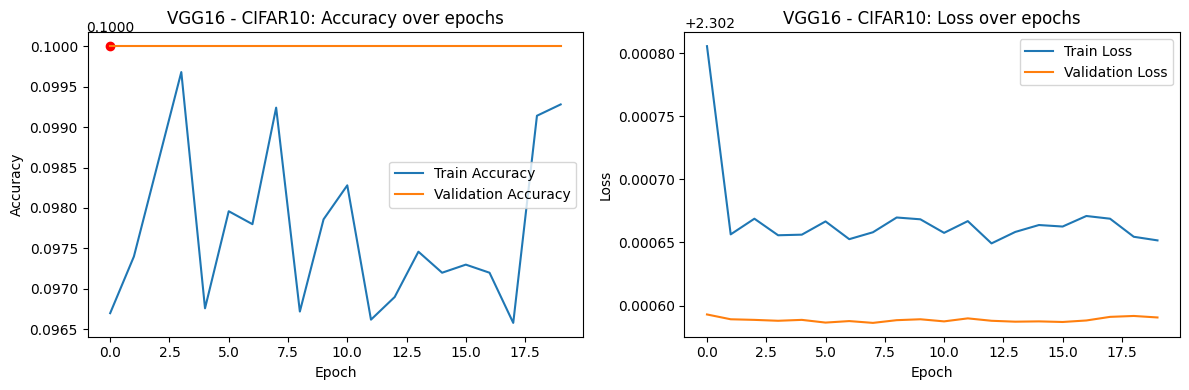

In [17]:
plt.figure(figsize=(12, 4))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(cifar10_history.history['accuracy'], label='Train Accuracy')
plt.plot(cifar10_history.history['val_accuracy'], label='Validation Accuracy')

# Annotate the maximum validation accuracy
max_val_acc = max(cifar10_history.history['val_accuracy'])
max_val_acc_idx = cifar10_history.history['val_accuracy'].index(max_val_acc)
plt.scatter(max_val_acc_idx, max_val_acc, color='red') # Highlight the max value with a red dot
plt.annotate(f'{max_val_acc:.4f}', (max_val_acc_idx, max_val_acc), textcoords="offset points", xytext=(0,10), ha='center') # Annotate the value

plt.title('VGG16 - CIFAR10: Accuracy over epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(cifar10_history.history['loss'], label='Train Loss')
plt.plot(cifar10_history.history['val_loss'], label='Validation Loss')
plt.title('VGG16 - CIFAR10: Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

## Can't get VGG-16 to train on CIFAR-10 from scratch. I'm not sure why. Time to move on to Tiny Imagenet

In [22]:
# Build the VGG16 model for Tiny Imagenet
model = Sequential()
model.add(VGG16(include_top=False, weights=None, input_shape=(64, 64, 3)))
model.add(Flatten())
model.add(Dense(200, activation="softmax"))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_6 (Flatten)         (None, 2048)              0         
                                                                 
 dense_8 (Dense)             (None, 200)               409800    
                                                                 
Total params: 15124488 (57.70 MB)
Trainable params: 15124488 (57.70 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
# Train the VGG16 Tiny Imagenet model
imagenet_history = model.fit(
    tiny_imagenet_train_gen,
    epochs=20,
    validation_data=tiny_imagenet_val_gen,
)

Epoch 1/20
1250/1250 [==============================] - 19s 14ms/step - loss: 5.2994 - accuracy: 0.0041 - val_loss: 5.2983 - val_accuracy: 0.0050
Epoch 2/20
1250/1250 [==============================] - 17s 14ms/step - loss: 5.2991 - accuracy: 0.0042 - val_loss: 5.2983 - val_accuracy: 0.0050
Epoch 3/20
1250/1250 [==============================] - 17s 14ms/step - loss: 5.2991 - accuracy: 0.0041 - val_loss: 5.2983 - val_accuracy: 0.0050
Epoch 4/20
1250/1250 [==============================] - 17s 14ms/step - loss: 5.2991 - accuracy: 0.0044 - val_loss: 5.2983 - val_accuracy: 0.0050
Epoch 5/20
1250/1250 [==============================] - 17s 13ms/step - loss: 5.2991 - accuracy: 0.0042 - val_loss: 5.2983 - val_accuracy: 0.0050
Epoch 6/20
1250/1250 [==============================] - 17s 14ms/step - loss: 5.2991 - accuracy: 0.0039 - val_loss: 5.2983 - val_accuracy: 0.0050
Epoch 7/20
1250/1250 [==============================] - 17s 14ms/step - loss: 5.2991 - accuracy: 0.0040 - val_loss: 5.2983 -

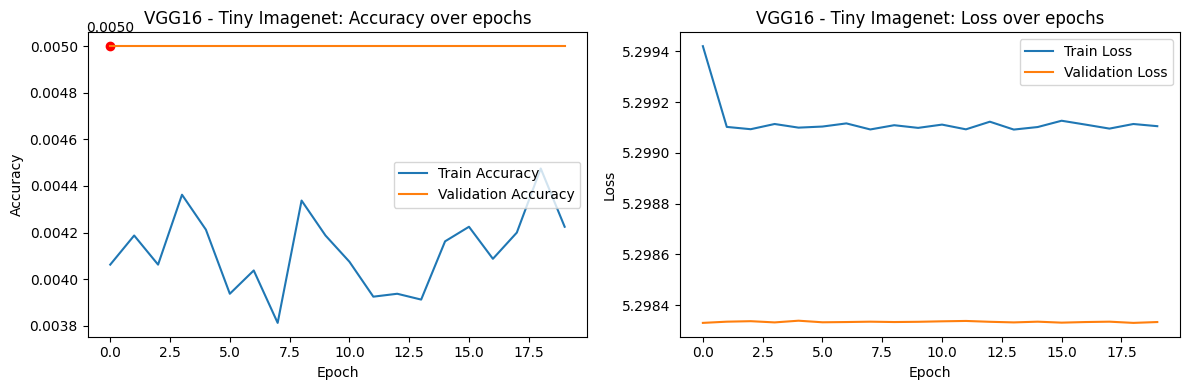

In [26]:
plt.figure(figsize=(12, 4))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(imagenet_history.history['accuracy'], label='Train Accuracy')
plt.plot(imagenet_history.history['val_accuracy'], label='Validation Accuracy')

# Annotate the maximum validation accuracy
max_val_acc = max(imagenet_history.history['val_accuracy'])
max_val_acc_idx = imagenet_history.history['val_accuracy'].index(max_val_acc)
plt.scatter(max_val_acc_idx, max_val_acc, color='red') # Highlight the max value with a red dot
plt.annotate(f'{max_val_acc:.4f}', (max_val_acc_idx, max_val_acc), textcoords="offset points", xytext=(0,10), ha='center') # Annotate the value

plt.title('VGG16 - Tiny Imagenet: Accuracy over epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(imagenet_history.history['loss'], label='Train Loss')
plt.plot(imagenet_history.history['val_loss'], label='Validation Loss')
plt.title('VGG16 - Tiny Imagenet: Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

## Trying to train VGG16 from scratch on either CIFAR-10 or Tiny Imagenet is not working. Let's try using the pretrained model. We'll use the version that's pre-trained on imagenet.

In [27]:
# Build the VGG16 model for CIFAR-10
model = Sequential()
model.add(VGG16(include_top=False, weights='imagenet', input_shape=(32, 32, 3)))
model.add(Flatten())
model.add(Dense(10, activation="softmax"))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_7 (Flatten)         (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 10)                5130      
                                                                 
Total params: 14719818 (56.15 MB)
Trainable params: 14719818 (56.15 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
# Model evaluation
test_loss, test_acc = model.evaluate(cifar10_test_images, cifar10_test_labels)
print("Test Accuracy:", test_acc)

313/313 [==============================] - 1s 3ms/step - loss: 2.6011 - accuracy: 0.0875
Test Accuracy: 0.08749999850988388


## VGG16 performs poorly on CIFAR-10 out of the box, which isn't a surprise. Let's try and fine tune it

In [30]:
# Create callback for saving model
checkpoint = ModelCheckpoint('../models/vgg16_cifar10.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

# Create the model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with frozen base
frozen_history = model.fit(
    cifar10_train_images, 
    cifar10_train_labels, 
    epochs=5, 
    batch_size=128, 
    validation_data=(cifar10_test_images, cifar10_test_labels)
    )

# Optional: Unfreeze some layers of the base model and continue training
for layer in base_model.layers[-4:]:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

unfrozen_history = model.fit(
    cifar10_train_images, 
    cifar10_train_labels, 
    epochs=20, 
    batch_size=16, 
    validation_data=(cifar10_test_images, cifar10_test_labels),
    callbacks=[checkpoint]
    )

Epoch 1/5
391/391 [==============================] - 3s 7ms/step - loss: 1.4074 - accuracy: 0.5109 - val_loss: 1.2673 - val_accuracy: 0.5555
Epoch 2/5
391/391 [==============================] - 3s 6ms/step - loss: 1.2017 - accuracy: 0.5827 - val_loss: 1.2132 - val_accuracy: 0.5759
Epoch 3/5
391/391 [==============================] - 2s 6ms/step - loss: 1.1446 - accuracy: 0.6003 - val_loss: 1.1850 - val_accuracy: 0.5830
Epoch 4/5
391/391 [==============================] - 2s 6ms/step - loss: 1.1042 - accuracy: 0.6156 - val_loss: 1.1592 - val_accuracy: 0.5944
Epoch 5/5
391/391 [==============================] - 2s 6ms/step - loss: 1.0743 - accuracy: 0.6252 - val_loss: 1.1511 - val_accuracy: 0.5943
Epoch 1/20
3123/3125 [============================>.] - ETA: 0s - loss: 0.9318 - accuracy: 0.6711
Epoch 1: val_accuracy improved from -inf to 0.68300, saving model to ../models/vgg16_cifar10.h5
3125/3125 [==============================] - 14s 4ms/step - loss: 0.9317 - accuracy: 0.6712 - val_los

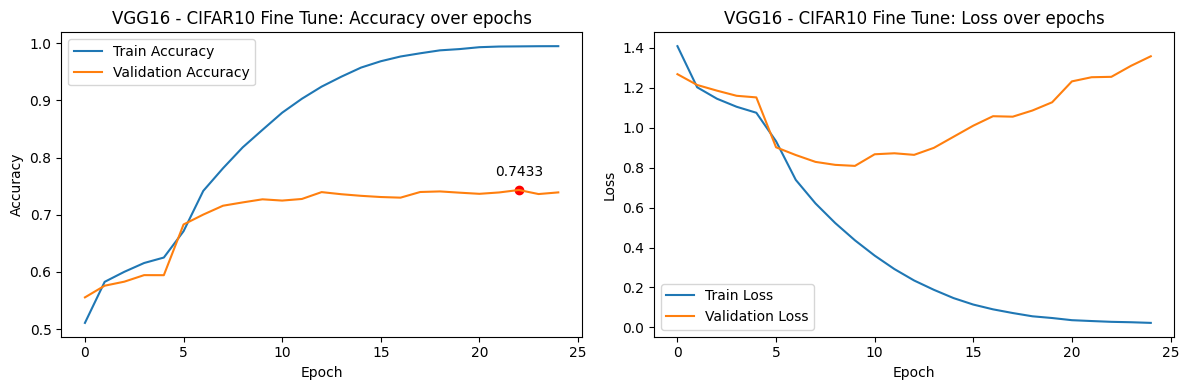

In [33]:
cifar10 = {}
for key in frozen_history.history:
    cifar10[key] = frozen_history.history[key] + unfrozen_history.history[key]

plt.figure(figsize=(12, 4))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(cifar10['accuracy'], label='Train Accuracy')
plt.plot(cifar10['val_accuracy'], label='Validation Accuracy')

# Annotate the maximum validation accuracy
max_val_acc = max(cifar10['val_accuracy'])
max_val_acc_idx = cifar10['val_accuracy'].index(max_val_acc)
plt.scatter(max_val_acc_idx, max_val_acc, color='red') # Highlight the max value with a red dot
plt.annotate(f'{max_val_acc:.4f}', (max_val_acc_idx, max_val_acc), textcoords="offset points", xytext=(0,10), ha='center') # Annotate the value

plt.title('VGG16 - CIFAR10 Fine Tune: Accuracy over epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(cifar10['loss'], label='Train Loss')
plt.plot(cifar10['val_loss'], label='Validation Loss')
plt.title('VGG16 - CIFAR10 Fine Tune: Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [34]:
# Model evaluation
model = load_model('../models/vgg16_cifar10.h5')

# Model evaluation
test_loss, test_acc = model.evaluate(cifar10_test_images, cifar10_test_labels)
print("Test Accuracy:", test_acc)

313/313 [==============================] - 1s 3ms/step - loss: 1.2540 - accuracy: 0.7433
Test Accuracy: 0.7433000206947327


## Now it's getting it. Let's see how it does with Tiny Imagenet

In [19]:
# Create the model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
model = Sequential([
    base_model,
    Flatten(),
    Dense(200, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_8 (Flatten)         (None, 2048)              0         
                                                                 
 dense_16 (Dense)            (None, 200)               409800    
                                                                 
Total params: 15124488 (57.70 MB)
Trainable params: 15124488 (57.70 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
# Model evaluation using the validation generator
val_loss, val_acc = model.evaluate(tiny_imagenet_val_gen, steps=tiny_imagenet_val_gen.samples // tiny_imagenet_val_gen.batch_size)
print("Validation Accuracy:", val_acc)

312/312 [==============================] - 2s 6ms/step - loss: 5.6406 - accuracy: 0.0050
Validation Accuracy: 0.004957932513207197


In [21]:
# Train the VGG-16 Tiny Imagenet model
imagenet_history = model.fit(
    tiny_imagenet_train_gen,
    epochs=10,
    validation_data=tiny_imagenet_val_gen,
)

Epoch 1/10
1250/1250 [==============================] - 18s 14ms/step - loss: 5.3030 - accuracy: 0.0040 - val_loss: 5.2983 - val_accuracy: 0.0050
Epoch 2/10
1250/1250 [==============================] - 17s 13ms/step - loss: 5.2991 - accuracy: 0.0045 - val_loss: 5.2983 - val_accuracy: 0.0050
Epoch 3/10
1250/1250 [==============================] - 17s 14ms/step - loss: 5.2991 - accuracy: 0.0041 - val_loss: 5.2983 - val_accuracy: 0.0050
Epoch 4/10
1250/1250 [==============================] - 17s 14ms/step - loss: 5.2991 - accuracy: 0.0044 - val_loss: 5.2983 - val_accuracy: 0.0050
Epoch 5/10
1250/1250 [==============================] - 17s 13ms/step - loss: 5.2991 - accuracy: 0.0043 - val_loss: 5.2983 - val_accuracy: 0.0050
Epoch 6/10
1250/1250 [==============================] - 17s 14ms/step - loss: 5.2991 - accuracy: 0.0044 - val_loss: 5.2983 - val_accuracy: 0.0050
Epoch 7/10
1250/1250 [==============================] - 17s 13ms/step - loss: 5.2991 - accuracy: 0.0041 - val_loss: 5.2983 -

## Same story as CIFAR10 - performing terrible. Let's try the fine tune

In [23]:
# Create the model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(200, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the VGG-16 Tiny Imagenet model with frozen base
frozen_imagenet_history = model.fit(
    tiny_imagenet_train_gen,
    epochs=5,
    validation_data=tiny_imagenet_val_gen,
    steps_per_epoch=tiny_imagenet_train_gen.samples // tiny_imagenet_train_gen.batch_size,
    validation_steps=tiny_imagenet_val_gen.samples // tiny_imagenet_val_gen.batch_size
)

# Optional: Unfreeze some layers of the base model and continue training
for layer in base_model.layers[-4:]:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Train the VGG-16 Tiny Imagenet model
unfrozen_imagenet_history = model.fit(
    tiny_imagenet_train_gen,
    epochs=10,
    validation_data=tiny_imagenet_val_gen,
    steps_per_epoch=tiny_imagenet_train_gen.samples // tiny_imagenet_train_gen.batch_size,
    validation_steps=tiny_imagenet_val_gen.samples // tiny_imagenet_val_gen.batch_size
)

Epoch 1/5
1250/1250 [==============================] - 9s 7ms/step - loss: 3.6712 - accuracy: 0.1964 - val_loss: 3.2354 - val_accuracy: 0.2630
Epoch 2/5
1250/1250 [==============================] - 9s 7ms/step - loss: 2.9954 - accuracy: 0.3057 - val_loss: 3.0687 - val_accuracy: 0.2963
Epoch 3/5
1250/1250 [==============================] - 8s 7ms/step - loss: 2.7637 - accuracy: 0.3508 - val_loss: 3.0340 - val_accuracy: 0.3034
Epoch 4/5
1250/1250 [==============================] - 8s 6ms/step - loss: 2.5997 - accuracy: 0.3808 - val_loss: 3.0189 - val_accuracy: 0.3129
Epoch 5/5
1250/1250 [==============================] - 8s 7ms/step - loss: 2.4669 - accuracy: 0.4068 - val_loss: 3.0196 - val_accuracy: 0.3138
Epoch 1/10
1250/1250 [==============================] - 9s 7ms/step - loss: 2.0972 - accuracy: 0.4870 - val_loss: 2.8553 - val_accuracy: 0.3562
Epoch 2/10
1250/1250 [==============================] - 8s 7ms/step - loss: 1.8566 - accuracy: 0.5395 - val_loss: 2.8507 - val_accuracy: 0.36

In [24]:
# Model evaluation using the validation generator
val_loss, val_acc = model.evaluate(tiny_imagenet_val_gen, steps=tiny_imagenet_val_gen.samples // tiny_imagenet_val_gen.batch_size)
print("Validation Accuracy:", val_acc)

312/312 [==============================] - 2s 5ms/step - loss: 3.0591 - accuracy: 0.3797
Validation Accuracy: 0.37965744733810425


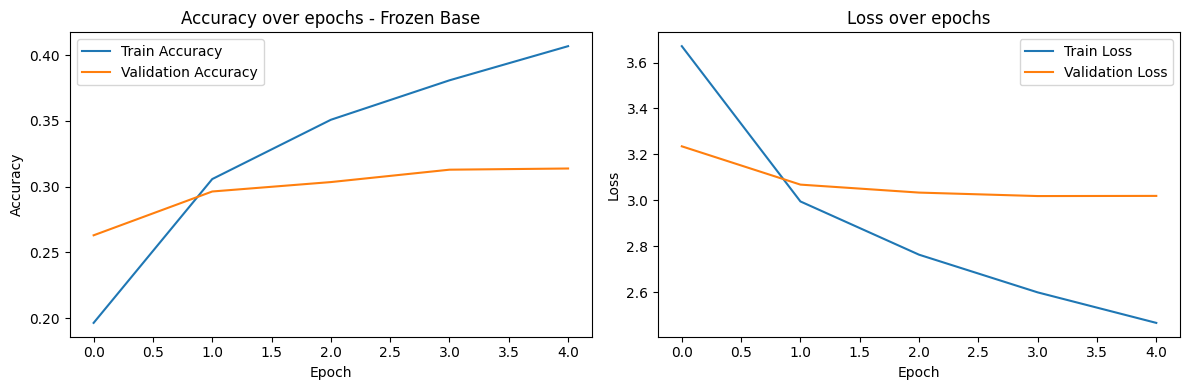

In [25]:
# Plotting Accuracy and Loss for frozen portion of training
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(frozen_imagenet_history.history['accuracy'], label='Train Accuracy')
plt.plot(frozen_imagenet_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs - Frozen Base')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(frozen_imagenet_history.history['loss'], label='Train Loss')
plt.plot(frozen_imagenet_history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

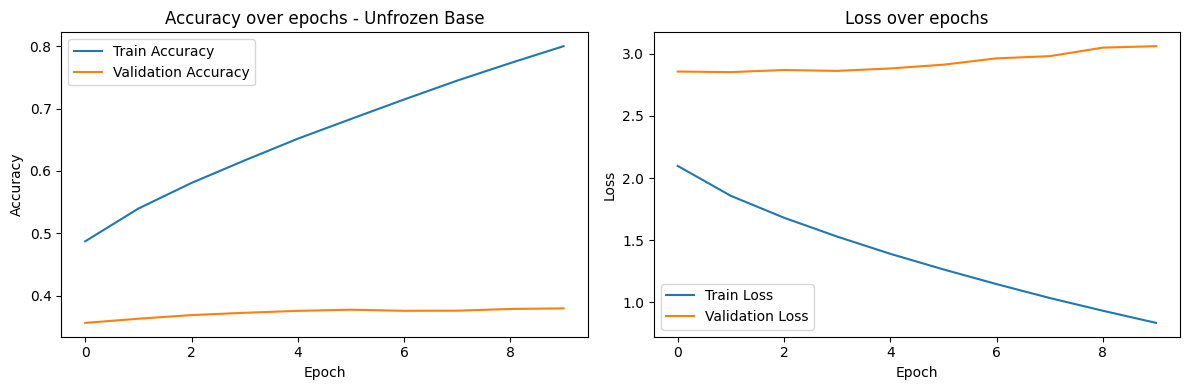

In [26]:
# Plotting Accuracy and Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(unfrozen_imagenet_history.history['accuracy'], label='Train Accuracy')
plt.plot(unfrozen_imagenet_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs - Unfrozen Base')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(unfrozen_imagenet_history.history['loss'], label='Train Loss')
plt.plot(unfrozen_imagenet_history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

## Holy overfitting Batman! Let's try adding some regularization and see if it helps

In [35]:
# Create callback for saving model
checkpoint = ModelCheckpoint('../models/vgg16_tiny_imagenet.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

# Create the model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dropout(.4),
    Dense(200, activation='softmax')
])

model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the VGG-16 Tiny Imagenet model with frozen base
frozen_imagenet_history = model.fit(
    tiny_imagenet_train_gen,
    epochs=5,
    validation_data=tiny_imagenet_val_gen,
)

# Optional: Unfreeze some layers of the base model and continue training
for layer in base_model.layers[-4:]:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Train the VGG-16 Tiny Imagenet model
unfrozen_imagenet_history = model.fit(
    tiny_imagenet_train_gen,
    epochs=20,
    validation_data=tiny_imagenet_val_gen,
    callbacks=[checkpoint]
)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_11 (Flatten)        (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_16 (Dense)            (None, 200)               409800    
                                                                 
Total params: 15124488 (57.70 MB)
Trainable params: 409800 (1.56 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________
Epoch 1/5
1250/1250 [==============================] - 9s 7ms/step - loss: 3.8148 - accuracy: 0.1864 - val_loss: 3.2385 - val_accuracy: 0.28

/home/robert/Dev/cs5870-assignment-1/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1244/1250 [============================>.] - ETA: 0s - loss: 2.2278 - accuracy: 0.4558
Epoch 2: val_accuracy improved from 0.36380 to 0.37440, saving model to ../models/vgg16_tiny_imagenet.h5
1250/1250 [==============================] - 9s 7ms/step - loss: 2.2284 - accuracy: 0.4556 - val_loss: 2.7388 - val_accuracy: 0.3744
Epoch 3/20
1246/1250 [============================>.] - ETA: 0s - loss: 2.0898 - accuracy: 0.4826
Epoch 3: val_accuracy improved from 0.37440 to 0.38545, saving model to ../models/vgg16_tiny_imagenet.h5
1250/1250 [==============================] - 9s 7ms/step - loss: 2.0894 - accuracy: 0.4827 - val_loss: 2.6971 - val_accuracy: 0.3855
Epoch 4/20
1241/1250 [============================>.] - ETA: 0s - loss: 1.9640 - accuracy: 0.5114
Epoch 4: val_accuracy improved from 0.38545 to 0.39185, saving model to ../models/vgg16_tiny_imagenet.h5
1250/1250 [==============================] - 8s 7ms/step - loss: 1.9636 - accuracy: 0.5116 - val_loss: 2.6714 - val_accuracy: 0.3918
Epo

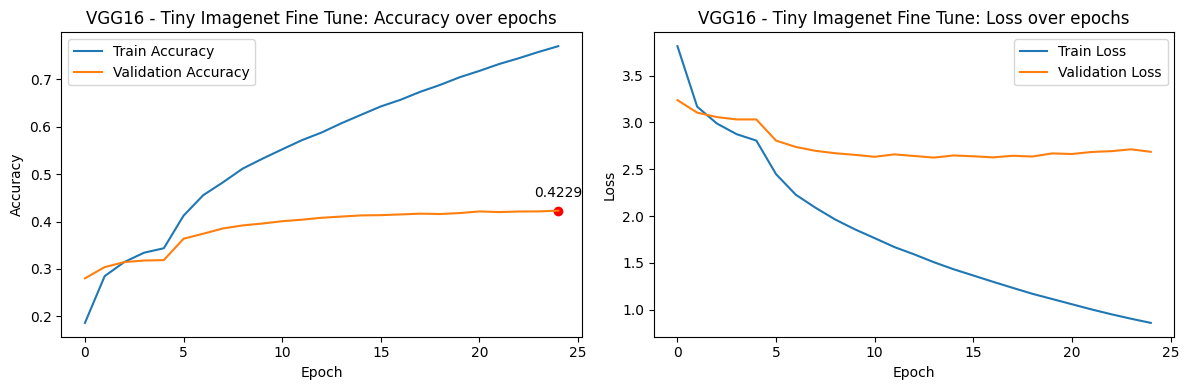

In [37]:
tiny_imagenet = {}
for key in frozen_imagenet_history.history:
    tiny_imagenet[key] = frozen_imagenet_history.history[key] + unfrozen_imagenet_history.history[key]

plt.figure(figsize=(12, 4))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(tiny_imagenet['accuracy'], label='Train Accuracy')
plt.plot(tiny_imagenet['val_accuracy'], label='Validation Accuracy')

# Annotate the maximum validation accuracy
max_val_acc = max(tiny_imagenet['val_accuracy'])
max_val_acc_idx = tiny_imagenet['val_accuracy'].index(max_val_acc)
plt.scatter(max_val_acc_idx, max_val_acc, color='red') # Highlight the max value with a red dot
plt.annotate(f'{max_val_acc:.4f}', (max_val_acc_idx, max_val_acc), textcoords="offset points", xytext=(0,10), ha='center') # Annotate the value

plt.title('VGG16 - Tiny Imagenet Fine Tune: Accuracy over epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(tiny_imagenet['loss'], label='Train Loss')
plt.plot(tiny_imagenet['val_loss'], label='Validation Loss')
plt.title('VGG16 - Tiny Imagenet Fine Tune: Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

## Much better on the overfitting front, but only nominal gains in accuracy. Let's move on to resnet-50